In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import emoji

from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import TargetEncoder, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, classification_report

In [2]:
def limpiar_texto(texto):
    # Reemplazar URLs por token
    texto = re.sub(r"http\S+|www\S+", " URL ", texto)
    # Reemplazar menciones (@usuario)
    texto = re.sub(r"@\w+", " USER ", texto)   
    # Reemplazar hashtags (dejando la palabra)
    texto = re.sub(r"#(\w+)", r" HASHTAG_\1 ", texto) 
    # Reemplazar emojis (usando su significado textual)
    texto = emoji.demojize(texto, language="en")  # 😊 → :cara_sonriente:
    texto = re.sub(r":([a-zA-Z0-9_]+):", r" EMOJI_\1 ", texto)
    # Eliminar caracteres especiales innecesarios
    texto = re.sub(r"[^a-zA-ZáéíóúÁÉÍÓÚñÑ0-9_\s]", " ", texto) 
    # Pasar a minúsculas
    texto = texto.lower() 
    # Quitar espacios múltiples
    texto = re.sub(r"\s+", " ", texto).strip()
    
    return texto

In [3]:
df = pd.read_csv("./data/train_with_features.csv")
test = pd.read_csv("./data/test_with_features.csv")

SEED = 42

X_train, X_validation, y_train, y_validation = train_test_split(df[['text', 'tiene_url', 'sentimiento']], df['target'], test_size=0.2, random_state=SEED)
mean_encoder = TargetEncoder(random_state=SEED)
one_hot_encoder = OneHotEncoder()
rf = RandomForestClassifier(random_state=SEED)
model_emb = SentenceTransformer('all-MiniLM-L6-v2')


In [4]:
x_sentimiento = mean_encoder.fit_transform(X_train[['sentimiento']], y_train)
x_url = one_hot_encoder.fit_transform(X_train[['tiene_url']]).toarray()

clean_text_train = X_train['text'].map(limpiar_texto)
x_emb_train = model_emb.encode(clean_text_train.tolist(), show_progress_bar=True)

x_train_final = np.hstack((x_emb_train, x_sentimiento, x_url))

parametros_rf = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 6, 7, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

rs_rf = RandomizedSearchCV(estimator=rf, param_distributions=parametros_rf,
                           n_iter=10, cv=5, scoring='f1', random_state=SEED, n_jobs=-1)

Batches: 100%|██████████| 191/191 [00:03<00:00, 50.69it/s]


In [5]:
rs_rf.fit(x_train_final, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,10
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [6]:
model = rs_rf.best_estimator_

In [7]:
x_sentimiento_val = mean_encoder.transform(X_validation[['sentimiento']])
x_url_val = one_hot_encoder.transform(X_validation[['tiene_url']]).toarray()

clean_text_val = X_validation['text'].map(limpiar_texto)
x_emb_val = model_emb.encode(clean_text_val.tolist(), show_progress_bar=True)

x_val_final = np.hstack((x_emb_val, x_sentimiento_val, x_url_val))

y_pred_rf = model.predict(x_val_final)

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

Batches: 100%|██████████| 48/48 [00:01<00:00, 47.46it/s]


In [8]:
accuracy_score(y_validation, y_pred_rf)


0.8227183191070256

In [9]:
roc_auc_score(y_validation, y_pred_rf)

0.8058710284789484

In [18]:
f1_score(y_validation, y_pred_rf)

0.7688356164383562

In [10]:
cm = confusion_matrix(y_validation, y_pred_rf)
cm

array([[804,  70],
       [200, 449]])

In [11]:
test = pd.read_csv("./data/test_with_features.csv")
test = test[['text', 'tiene_url', 'sentimiento']]

In [12]:
test_sentimiento = mean_encoder.transform(test[['sentimiento']])
test_url = one_hot_encoder.transform(test[['tiene_url']]).toarray()

clean_text_test = test.text.map(limpiar_texto)
test_emb = model_emb.encode(clean_text_test.tolist(), show_progress_bar=True)

test_encoded = np.hstack((test_emb, test_sentimiento, test_url))

pred_tests =  model.predict(test_encoded)

Batches: 100%|██████████| 102/102 [00:01<00:00, 58.07it/s]


In [13]:
test = pd.read_csv("./data/test_with_features.csv")
submission_df = pd.DataFrame({
    'id': test['id'],
    'target': pred_tests
})
submission_df.to_csv('./submission/random_forest_submission.csv', index=False)

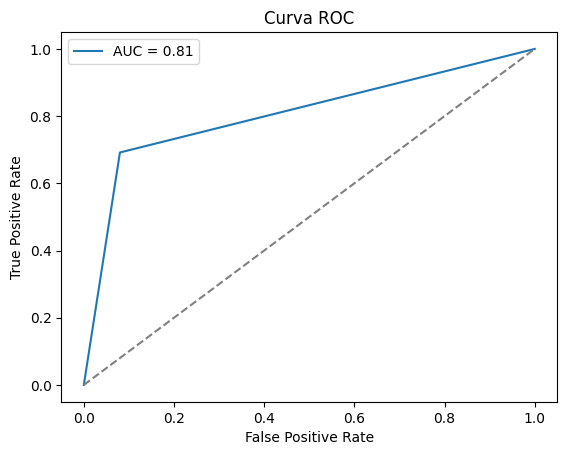

In [14]:
fpr, tpr, _ = roc_curve(y_validation, y_pred_rf)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_validation, y_pred_rf):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

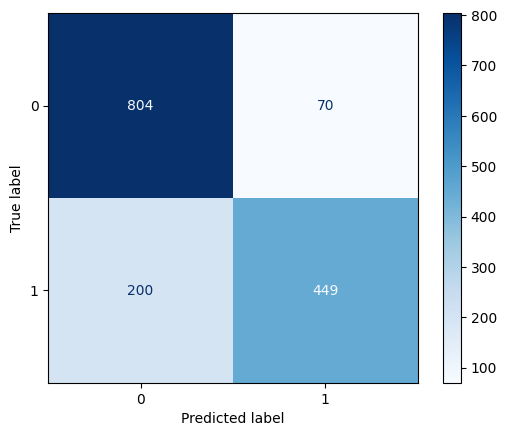

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay


ConfusionMatrixDisplay(confusion_matrix(y_validation, y_pred_rf)).plot(cmap='Blues')
plt.show()